In [110]:
import os, sys, time, argparse
import matplotlib.pyplot as plt
import numpy as np
import json
import ray

#ray.init(log_to_driver=False)

def load_swarm_data(filename):
    with open(filename) as json_file:
        swarm_data = json.load(json_file)
    # Grab the total number of integrations
    n_data = len(swarm_data)

    
    # 'cal_solution', 'delays', 'efficiencies', 'inputs', 'int_length', 'int_time', 'phases'
    if 'phases' in swarm_data[0].keys():
        # Phases is the "old" keyword, where DSB phasing wasn't used.
        input_count = np.median([len(swarm_data[idx]['inputs']) for idx in range(n_data)])
        use_data = [
            (len(swarm_data[idx]['inputs']) == input_count)
            and (len(swarm_data[idx]['phases']) == input_count)
            and (len(swarm_data[idx]['cal_solution'][2]) == input_count)
            for idx in range(n_data)
        ]

        swarm_data = [swarm_data[idx] for idx in range(n_data) if use_data[idx]]
        n_data = len(swarm_data)

        # These are the implemented phase values recorded in SWARM
        phase_online = np.array([swarm_data[idx]['phases'] for idx in range(n_data)])
        # These are the derived phase offsets post-correlation
        phase_solns = np.array([swarm_data[idx]['cal_solution'][2] for idx in range(n_data)])
        
        # Add the two to get the "true" value at the time
        true_phases = phase_online[1:] + phase_solns[:-1]
        prog_vals = phase_online
    else:
        input_count = np.median([[len(data['inputs_lsb']), len(data['inputs_usb'])] for data in swarm_data])

        use_data = [
            (len(swarm_data[idx]['inputs_lsb']) == input_count)
            and (len(swarm_data[idx]['phases_lsb']) == input_count)
            and (len(swarm_data[idx]['cal_solution_lsb'][2]) == input_count)
            and (len(swarm_data[idx]['inputs_usb']) == input_count)
            and (len(swarm_data[idx]['phases_usb']) == input_count)
            and (len(swarm_data[idx]['cal_solution_usb'][2]) == input_count)
            for idx in range(n_data)
        ]

        swarm_data = [swarm_data[idx] for idx in range(n_data) if use_data[idx]]
        n_data = len(swarm_data)

        # We're gonna be doing a lot of diff operations, which means in some cases we'll want
        # to pad some arrays with zeros. Construct some arrays now for the sake of convenience
        # These are the implemented phase values recorded in SWARM
        phases_lsb = np.array([data['phases_lsb'] for data in swarm_data])
        phases_usb = np.array([data['phases_usb'] for data in swarm_data])

        # These are the derived offsets/error terms for each antenna, given the implemented values
        cal_solution_lsb = np.array([data['cal_solution_lsb'][2] for data in swarm_data])
        cal_solution_usb = np.array([data['cal_solution_usb'][2] for data in swarm_data])

        # Let's calculate the "true" phase -- that is, assume that the solutions are perfect, and
        # use that to figure out what the antenna phase should _actually_ have been at time of obs.
        # There's kind of a funny padding operation that's needed here because of the order values
        # in the JSON file are recorded (soln's derived -> values implemented -> values recorded).
        true_phases = np.concatenate(
            (phases_lsb[:-1] + cal_solution_lsb[1:], phases_usb[:-1] + cal_solution_usb[1:]), axis=1,
        )

        prog_vals = np.concatenate((phases_lsb, phases_usb), axis=1)

    # Convert times from UNIX -> fractional UTC hours
    time_stamps = (np.array([data['int_time'] for data in swarm_data]) % 86400) / 3600.0
    
    return (true_phases, time_stamps)

#@ray.remote
def sim_pid_loop(phase_data, int_length=8, kp=0.75, ki=0.40, kd=0.01):
    n_times = phase_data.shape[0]
    n_inputs = phase_data.shape[1]
    int_window = np.zeros((int_length, n_inputs))
    int_term = np.zeros(n_inputs)
    new_epsilon = np.zeros((n_times, n_inputs))
    pid_arr = np.zeros((n_times, n_inputs))
    last_cal = np.array(phase_data[0])
    last_epsilon = np.array(phase_data[0])

    for idx in range(n_times):
        cal_soln = (((phase_data[idx] - last_cal) + 180.0 ) % 360.0) - 180.0
        new_epsilon[idx] = cal_soln
        pos_mark = np.mod(idx, int_length)
        int_term += (cal_soln - int_window[pos_mark])
        int_window[pos_mark] = cal_soln
        del_term = cal_soln - last_epsilon

        pid_response = (
            (kp * cal_soln)
            + (int_term * (ki / int_length))
            + (del_term * kd)
        )
        last_cal += pid_response
        last_cal = ((last_cal + 180.0 ) % 360.0) - 180.0
        last_epsilon = cal_soln
        pid_arr[idx] = pid_response

    ph_eff_vals = (np.abs(
        np.mean(np.exp(-1j*np.deg2rad(new_epsilon.reshape((n_times, 8, -1)))),axis=2)
    )**2.0).astype(np.float32)

    return ph_eff_vals, pid_arr

(1773, 48)


(-20.0, 20.0)

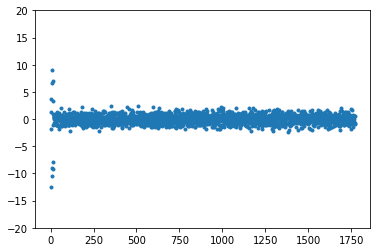

In [36]:
data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.107-2021.json'
phase_arr, prog_arr, time_vals = load_swarm_data(data_file)
_, pid_response = sim_pid_loop(phase_arr)
print(pid_response.shape)
eval_vals = (pid_response[1:,2] - np.diff(prog_arr[:,2], axis=0))
eval_vals[eval_vals < -180.0] += 360.0
eval_vals[eval_vals > 180.0] -= 360.0

_ = plt.plot(eval_vals, '.')
plt.ylim([-20, 20])

In [2]:
%%time
data_file = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.107-2021.json'

n_kp = 21
kp_range = [0., 2.]
n_ki = 26
ki_range = [-10, 15]
n_kd = 21
kd_range = [-1., 1.]

n_int = 1
int_start = 3
int_step = 3

phase_arr, time_vals = load_swarm_data(data_file)
n_times = phase_arr.shape[0]
phase_arr_id = ray.put(phase_arr)
pid_arr = {}
print("Processing", end="")
sys.stdout.flush()

for idx, kp in enumerate(np.linspace(kp_range[0], kp_range[1], num=n_kp)):
    for jdx, ki in enumerate(np.linspace(ki_range[0], ki_range[1], num=n_ki)):
        for kdx, kd in enumerate(np.linspace(kd_range[0], kd_range[1], num=n_kd)):
            for ldx, int_length in enumerate(np.arange(int_start, int_start + (int_step * n_int) , int_step)):
                pid_arr[sim_pid_loop.remote(phase_arr_id, int_length=int_length, kp=kp, ki=ki, kd=kd)] = (idx,jdx,kdx,ldx)
    print(".", end="")
    sys.stdout.flush()
print("complete!")

results_arr = np.zeros((n_kp, n_ki, n_kd, n_int, n_times, 8), dtype=np.float32)
print("Recording", end="")
sys.stdout.flush()
while pid_arr != {}:
    ready_ids, not_ready_ids = ray.wait(list(pid_arr.keys()), num_returns=n_ki*n_kd*n_int)
    for obj_id in ready_ids:
        results_arr[pid_arr[obj_id]] = ray.get(obj_id)
        del pid_arr[obj_id]
    print(".", end="")
    sys.stdout.flush()
print("complete!")


Processing.....................complete!
Recording.....................complete!
CPU times: user 15.1 s, sys: 5.22 s, total: 20.3 s
Wall time: 1min 7s


In [43]:
results_arr.size

162633744

In [52]:
start_time = time.time()
print('Prox done in %g seconds' % (time.time() - start_time))


Prox done in 5.48363e-05 seconds


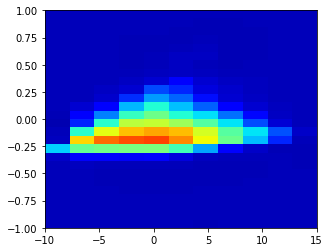

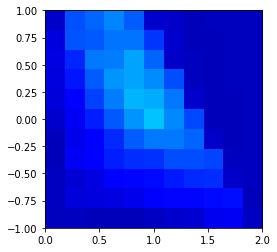

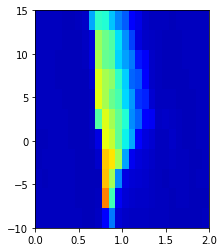

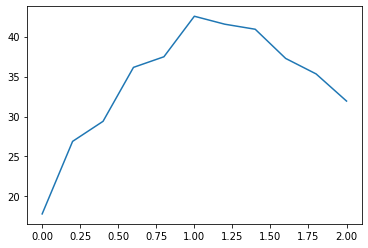

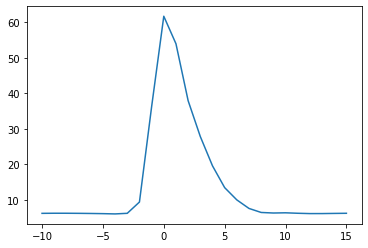

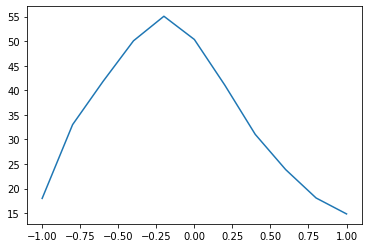

In [15]:
plt.imshow(np.mean(results_arr/np.max(results_arr > 0.),axis=0), extent=np.array([ki_range, kd_range]).flatten(), origin='lower', cmap='jet', aspect=10)
plt.clim([0, 1])
plt.show()
plt.imshow(np.mean(results_arr/np.max(results_arr),axis=1), extent=np.array([kp_range, kd_range]).flatten(), origin='lower', cmap='jet', aspect=1)
plt.clim([0, 1])
plt.show()
plt.imshow(np.mean(results_arr/np.max(results_arr),axis=2), extent=np.array([kp_range, ki_range]).flatten(), origin='lower', cmap='jet', aspect=0.1)
plt.clim([0, 1])
plt.show()
plt.plot(np.linspace(kp_range[0], kp_range[1], num=n_kp), results_arr.sum(axis=2).sum(axis=1))
plt.show()
plt.plot(np.linspace(ki_range[0], ki_range[1], num=n_ki), results_arr.sum(axis=2).sum(axis=0))
plt.show()
plt.plot(np.linspace(kd_range[0], kd_range[1], num=n_kd), results_arr.sum(axis=1).sum(axis=0))
plt.show()

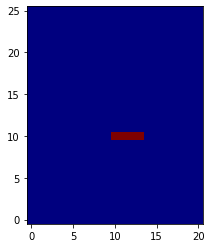

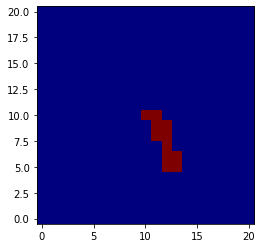

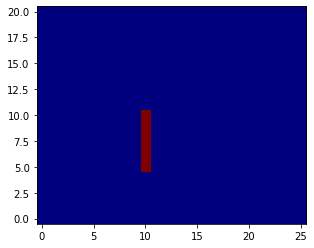

In [38]:
data = np.load('/Users/gkeating/test.npy')
data = np.sum(np.sum(data > 0.75, axis=5), axis=4).astype(float)
data /= data.max()
data = data[:,:,:,0]

plt.imshow(np.any(data > 0.999,axis=0), origin='lower', cmap='jet')
plt.clim([0,1])
plt.show()
plt.imshow(np.any(data > 0.999,axis=1), origin='lower', cmap='jet')
plt.clim([0,1])
plt.show()
plt.imshow(np.any(data > 0.999,axis=2), origin='lower', cmap='jet')
plt.clim([0,1])
plt.show()
#plt.plot((data > 0.9).sum(axis=5).sum(axis=4).sum(axis=2).sum(axis=1).sum(axis=0))

In [119]:
import glob
data_path = '/Users/gkeating/repo/sma_phasing_sims/phasing_data/'
file_list = glob.glob(data_path + '/*')

for file in file_list:
    try:
        load_swarm_data(file)
    except:
        print(file)


In [118]:

with open('/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.320-2017.json') as json_file:
    swarm_data = json.load(json_file)

print(swarm_data[-1].keys())


FileNotFoundError: [Errno 2] No such file or directory: '/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.320-2017.json'

In [114]:
_ = load_swarm_data('/Users/gkeating/repo/sma_phasing_sims/phasing_data/vlbi_cal.320-2017.json')

KeyError: 'inputs_lsb'